In [1]:
# Common stuff reused by all applications
from analysis_common import *
%matplotlib inline


EXPERIMENT_SIZE_FIELDS = [
    "number_of_fragments", 
    "points_per_fragment", 
]

PLATFORM_FIELDS = [
    "nodes",
    "cpus_per_node",
    "backends_per_node",
]

HANDPICKED_OUTLIERS = [
    23781312, 23781315, 23781286, 23781294, 23781297, 23747333, 
    23747318, 23748308,
    23781323, 23781301,
    23781369, 23903522,
    23903530,
    23903555, 23903557, 23903547, 23903543, 23903542, 23903531,
    23903573, 23903567
]

In [2]:
db = DataStorage("csvm-split")
df = prepare_df(db, HANDPICKED_OUTLIERS)

In [3]:
edf = df.explode("execution_time").sort_values('mode')
edf['execution_time'] = edf['execution_time'].astype(float)

# Weak scaling (small blocks)


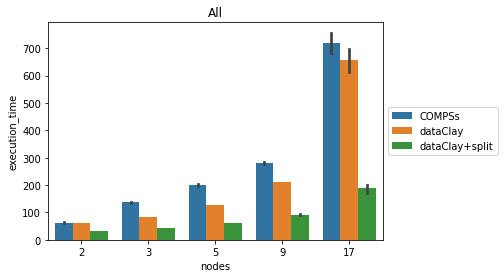

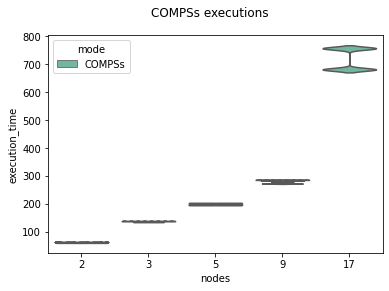

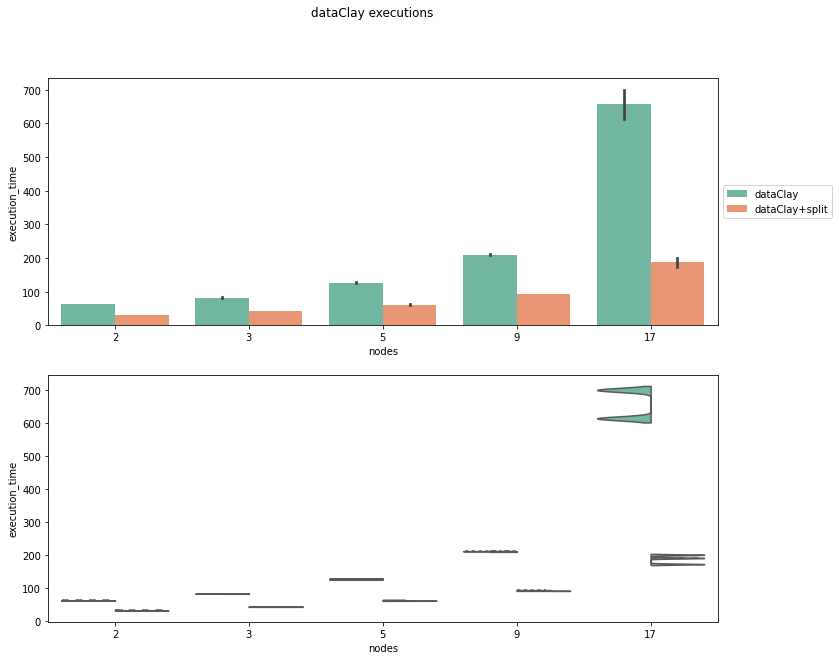

initialization_time  execution_time  split_overhead_time
nodes mode                                                                    
2     COMPSs                    19.756007       62.128287                  NaN
      dataClay                  57.881934       62.312165             7.230713
      dataClay+split            57.359621       31.564803             6.656493
3     COMPSs                    18.916484      136.835939                  NaN
      dataClay                  71.502003       82.481270             8.658333
      dataClay+split            73.412438       43.057921            12.211147
5     COMPSs                    19.453035      198.568984                  NaN
      dataClay                 133.314067      126.758022            12.774601
      dataClay+split           132.817341       61.591841            20.135567
9     COMPSs                    20.244118      280.361613                  NaN
      dataClay                 259.815981      210.174370            23.340494
      dataClay+split           259.047448       91.909353            39.412902
17    COMPSs                    19.912804      718.651836                  NaN
      dataClay                 516.830511      655.687557            45.120938
      dataClay+split           516.683995      187.411669            68.110552

In [4]:
# Weak scaling
data = edf.query("((number_of_fragments / (nodes - 1)) == 384) and (points_per_fragment == 128)")
small_blocks_data = data.copy()
small_blocks_data["nodes"] -= 1

plot_things(data, "execution_time")

data = data.drop(data.columns.difference(["nodes", "mode", "execution_time","split_overhead_time", "initialization_time"]), axis="columns")
data.groupby(["nodes", "mode"]).mean()

## Weak scaling (big blocks)

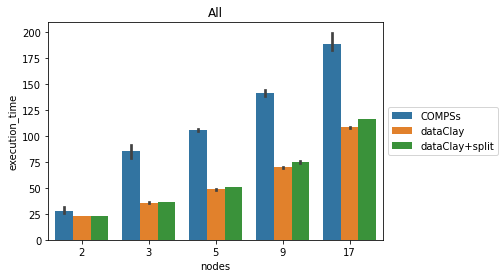

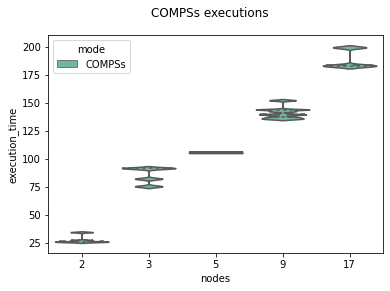

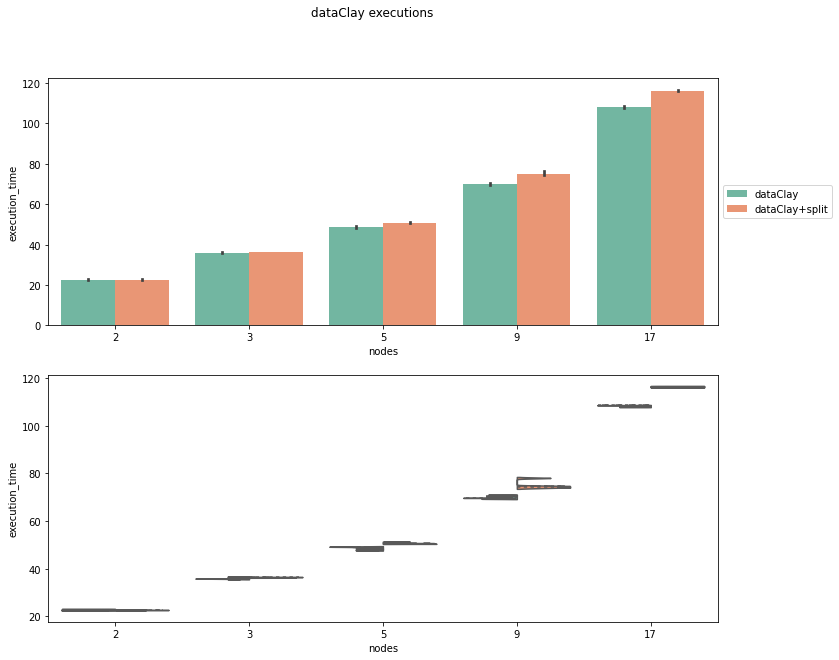

initialization_time  execution_time  split_overhead_time
nodes mode                                                                    
2     COMPSs                    17.197047       27.944435                  NaN
      dataClay                  58.008320       22.662262             0.672494
      dataClay+split            57.814061       22.636337             1.890151
3     COMPSs                    16.922967       85.229215                  NaN
      dataClay                  72.570946       35.902342             1.607289
      dataClay+split            72.453239       36.299154             3.853843
5     COMPSs                    16.596580      105.764777                  NaN
      dataClay                 133.143819       48.646818             3.648488
      dataClay+split           133.167427       50.721642             8.499784
9     COMPSs                    17.848291      141.214451                  NaN
      dataClay                 255.948848       69.940279             7.475863
      dataClay+split           256.803988       75.106422            17.338770
17    COMPSs                    18.654985      188.577785                  NaN
      dataClay                 502.036298      108.274648             8.941590
      dataClay+split           502.784977      116.289553            30.531599

In [5]:
# Weak scaling, with big blocks (48 blocks per node)
data = edf.query("((number_of_fragments / (nodes - 1)) == 48) and ((points_per_fragment) == (128 * 8))")
big_blocks_data = data.copy()
big_blocks_data["nodes"] -= 1

plot_things(data, "execution_time")
plt.show()

data = data.drop(data.columns.difference(["nodes", "mode", "execution_time","split_overhead_time", "initialization_time"]), axis="columns")
data.groupby(["nodes", "mode"]).mean()

## Blocksize sweep


In [6]:
# Weak scaling, with big blocks (48 blocks per node)
data = edf.query("(nodes == 9) and ((number_of_fragments * points_per_fragment) == 393216)")

def eval_granularity_index(row):
    index = row["number_of_fragments"] // (48 * 8)
    row["granularity_index"] = index
    row["blocks_per_core"] = "%sx" % index
    return row

data = data.apply(eval_granularity_index, axis=1)
sweep_data = data.copy()

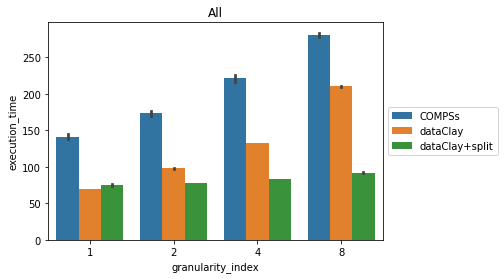

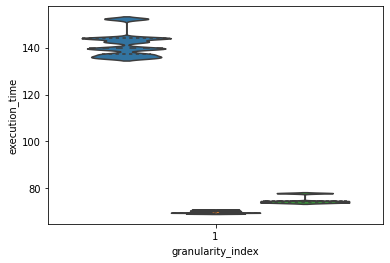

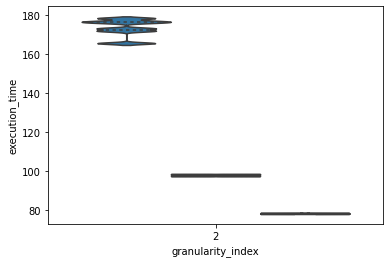

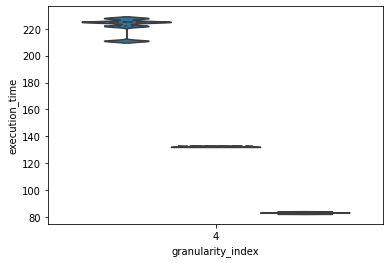

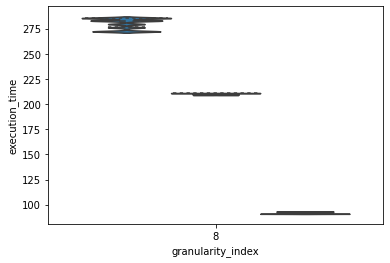

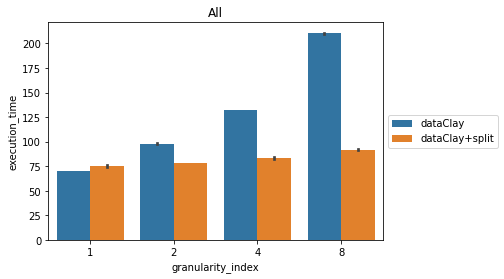

initialization_time  execution_time  \
granularity_index mode                                                  
1                 COMPSs                    17.848291      141.214451   
                  dataClay                 255.948848       69.940279   
                  dataClay+split           256.803988       75.106422   
2                 COMPSs                    18.623557      173.901174   
                  dataClay                 256.773120       97.928545   
                  dataClay+split           259.203985       78.149015   
4                 COMPSs                    17.231334      222.245287   
                  dataClay                 254.953073      132.481689   
                  dataClay+split           257.923425       83.364973   
8                 COMPSs                    20.244118      280.361613   
                  dataClay                 259.815981      210.174370   
                  dataClay+split           259.047448       91.909353   

                                  split_overhead_time  
granularity_index mode                                 
1                 COMPSs                          NaN  
                  dataClay                   7.475863  
                  dataClay+split            17.338770  
2                 COMPSs                          NaN  
                  dataClay                   8.891128  
                  dataClay+split            20.472953  
4                 COMPSs                          NaN  
                  dataClay                  12.853371  
                  dataClay+split            26.057195  
8                 COMPSs                          NaN  
                  dataClay                  23.340494  
                  dataClay+split            39.412902

In [7]:
sns.barplot(data=data, x="granularity_index", hue="mode", y="execution_time", 
            estimator=ESTIMATOR_TO_USE)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("All")
# TODO: Change granularity_index to: fragments per core [o algo així]
plt.show()

for i in [1, 2, 4, 8]:
    ax = sns.violinplot(data=data.query("granularity_index == %d" % i),
                        x="granularity_index", hue="mode", y="execution_time", 
                        scale='width', bw=VIOLIN_BW,
                        inner="quartile", figsize=123)
    ax.get_legend().remove()
    plt.show()

sns.barplot(data=data.query("dataclay == 1"), x="granularity_index", hue="mode", y="execution_time", 
            estimator=ESTIMATOR_TO_USE)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("All")
plt.show()

data = data.drop(data.columns.difference(["granularity_index", "mode", "execution_time","split_overhead_time", "initialization_time"]), axis="columns")
data.groupby(["granularity_index", "mode"]).mean()

## Reminder for the future

~~We have seen certain behavior regarding the number of blocks and its effect. Check that it really is due to the SVD and diagonalization.~~

~~Keep that in mind (not for the article, but probably the thesis).~~

That was false!

Code was already merging blocks into a single SVD decomposition (and using the get_indexes for knowing the real indexes of the split partition).

# Figure generation

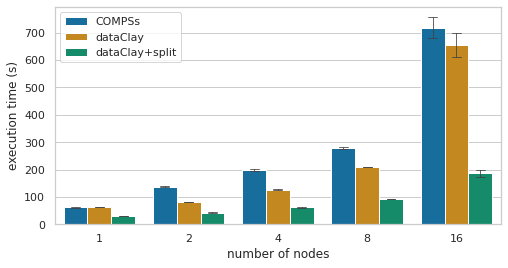

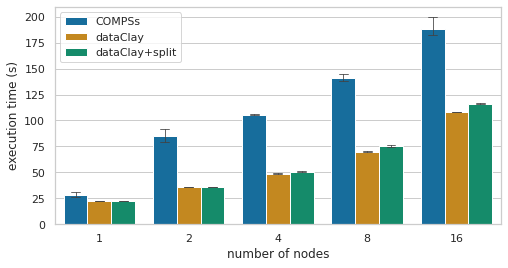

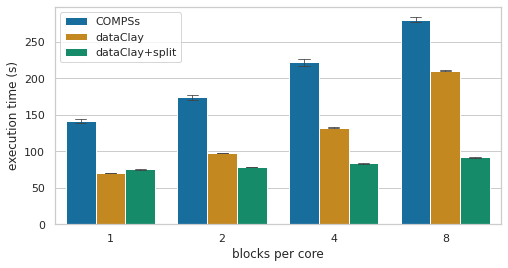

In [8]:
sns.set(style="whitegrid", color_codes=True)

ax = sns.barplot(y="execution_time", x="nodes", hue="mode",
                 data=small_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 palette="colorblind")

ax.legend().title = ""
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

save_tweaks("csvm-weakscaling_smallblocks.pdf")
plt.show()

ax = sns.barplot(y="execution_time", x="nodes", hue="mode",
                 data=big_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 palette="colorblind")

ax.legend().title = ""
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

save_tweaks("csvm-weakscaling_bigblocks.pdf")
plt.show()

ax = sns.barplot(y="execution_time", x="granularity_index", hue="mode",
                 data=sweep_data,
                 capsize=0.1,
                 errwidth=0.8,
                 palette="colorblind")

ax.legend().title = ""
ax.set_ylabel("execution time (s)")
ax.set_xlabel("blocks per core")

save_tweaks("csvm-blocksweep.pdf")
plt.show()
